In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import fastai
import pydicom as dicom
from pydicom.filereader import read_dicomdir
from fast_dicom import *

In [3]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS")

In [99]:
study_paths = sorted([i for i in (PATH).ls() if 'zip' not in str(i) ])

In [100]:
study_paths

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/75mm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0083'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0090'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0094'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0099'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0109'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0110'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0111'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0125'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0131'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0141'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0145'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0156'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0157'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0165'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0168'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0197'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0215'),
 PosixPath('/home/vhl_ai/Data/MRI

In [101]:
slices = sorted([i for i in Path('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/').ls()])
slices

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0000.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0001.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0002.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0003.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0004.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0005.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0006.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0007.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0008.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0009.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0010.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0011.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0012.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0013.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/

In [4]:
class ProcessDCM():
    def __init__(self, study_path, new_spacing=np.array([1.,1.,1.])):
        self.new_spacing = new_spacing if new_spacing is not None else None
        self.study_path = study_path
        
    def get_scan(self, slices):
        scan, px_spacing = self.proc_scan_files((slices))
        return scan, px_spacing
    
    def proc_scan_files(self, slices):
        scan_files = (dicom.read_file(str(i)) for i in slices)
        scan_files = sorted(scan_files, key=lambda x: x.ImagePositionPatient[-1])
        
        #spacing information for conversion
        slice_dist = [abs(float(a.ImagePositionPatient[-1]) - float(b.ImagePositionPatient[-1])) for a,b in zip(scan_files[1:], scan_files[:-1])]
        slice_dist = max_agree(slice_dist)
        px_spacing = list(max_agree([tuple([float(i) for i in f.PixelSpacing]) for f in scan_files]))
        slice_dist, px_spacing
        
        #conversion should always be identity so this will almost always be redundant
        slope, intercept = map(float, [scan_files[0].RescaleSlope, scan_files[0].RescaleIntercept])
        stack = [(i.pixel_array * slope) + intercept for i in scan_files][::-1]
        slope, intercept, np.shape(stack)
    
        #remove extraneous slices with wrong dim
        max_dim = max_agree([i.shape for i in stack])
        stack = np.stack([i for i in stack if tuple(i.shape) == max_dim])
        return stack, np.array([slice_dist] + px_spacing[::-1])
    
class GetDCM():
    #Class for setting up mri scan and mask pathways to easily generate data
    def __init__(self, study_path):
        self.study_path = study_path
        
    def get_scan_names(self):
        #get list of all MRI scans in the dataset
        mri_scans = sorted([str(os.path.basename(i)) for i in (self.study_path).ls() if '.csv' not in str(i) ])
        return mri_scans
    
    def get_scan_mask(self):
        #retrieve all mri dicom slices from designated scan
        scan_list = self.get_scan_names()
        scan_slices = sorted([i for i in Path(PATH / scan_list[1] / 'Raw').ls()])
        mask_slices = sorted([i for i in Path(PATH / scan_list[1] / 'Mask').ls()])
        return scan_slices, mask_slices
        


In [5]:
gdcm = GetDCM(PATH)

In [6]:
foo_scan, foo_mask = gdcm.get_scan_mask()
foo_scan

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0000.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0001.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0002.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0003.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0004.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0005.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0006.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0007.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0008.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0009.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0010.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0011.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0012.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/HH59_0013.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/

In [7]:
PDCM = ProcessDCM(PATH)

In [10]:
foo_scan, foo_ps = PDCM.get_scan(foo_scan)
foo_mask, foo_mask_ps = PDCM.get_scan(foo_mask)

In [11]:
np.shape(foo_mask), foo_mask_ps

((104, 512, 512), array([0.022789, 0.292969, 0.292969]))

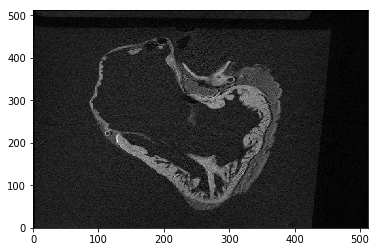

In [12]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_scan[73, :, :]))

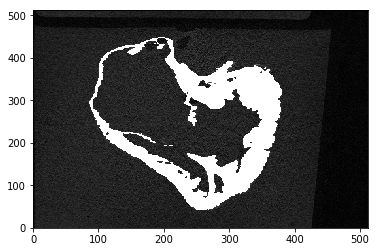

In [13]:
plt.set_cmap(plt.gray())
plt.pcolormesh(np.flipud(foo_mask[73, :, :]))

In [13]:
mask_slices = sorted([i for i in Path('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/').ls()])
mask_slices

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0000.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0001.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0002.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0003.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0004.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0005.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0006.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0007.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0008.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0009.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0010.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0011.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0012.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0013.dcm'),
 PosixPath('/home/vh

In [14]:
len(mask_slices)

104

In [15]:
ref = dicom.read_file(str(mask_slices[0]))
const_dims = (int(ref.Rows), int(ref.Columns), len(slices))
print(const_dims)
const_pix_space = (float(ref.PixelSpacing[0]), float(ref.PixelSpacing[1]), float(ref.SliceThickness))
print(const_pix_space)

(512, 512, 104)
(0.29296875, 0.29296875, 1.0)


In [16]:
x = np.arange(0.0, (const_dims[0]+1)*const_pix_space[0], const_pix_space[0])
y = np.arange(0.0, (const_dims[1]+1)*const_pix_space[1], const_pix_space[1])
z = np.arange(0.0, (const_dims[2]+1)*const_pix_space[2], const_pix_space[2])

In [17]:
mask_array_dicom = np.zeros(const_dims, dtype=ref.pixel_array.dtype)
np.shape(mask_array_dicom)

(512, 512, 104)

In [20]:
for mask_file in mask_slices:
    ds = dicom.read_file(str(mask_file))
    mask_array_dicom[:,:,mask_slices.index(mask_file)] = ds.pixel_array

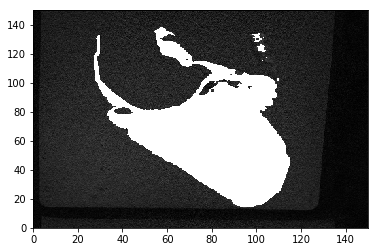

In [25]:
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(mask_array_dicom[:, :, 73]))

In [27]:
np.max(mask_array_dicom), np.min(mask_array_dicom)

(2371, 0)

In [31]:
foo_mask = np.where(mask_array_dicom != np.max(mask_array_dicom), 0, mask_array_dicom)

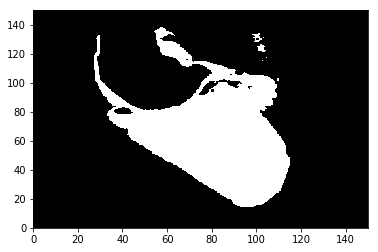

In [32]:
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(foo_mask[:, :, 73]))